- fhs_flashsale_product: (Thông tin flashsale của product)
    * period_id : id của flashsale
    * product_id : id của product 
    * original_price : giá gốc
    * flashsale_price : giá sale
    * total_items : số lượng sale
    
- fhs_flashsale_period: (Chứa thông tin flashsale về thời gian)
    * id: id của flashsale (== period_id của fhs_flashsale_product)
    * start_date, end_date: time bắt đầu kết thúc sale 
    * các cột khác không quan tâm
    
- fhs_catalog_product_entity: (Thông tin discount và ngày bắt đầu bán)
    * entity_id: id của product (==product_id trong fhs_flashsale_product)
    * sku : là mã sản phẩm (duy nhất và là khóa của sản phẩm dùng để truy các thông tin khác về sản phẩm)
    * created_at : ngày bắt đầu bán
    * discount_percent : phần trăm giảm giá so với giá bìa (trừ flashsale còn giá sản phẩm mọi lúc sẽ là giá gốc trừ đi disount này)

- fhs_cataloginventory_stock_item: Bãng này là số lượng sản phẩm tồn nhưng ko dùng được, do bên db bị mất dữ liệu
    
- fhs_sales_flat_order: Chứa thông tin đơn hàng
    * entity_id : id của đơn hàng (==order_id trong fhs_sales_flat_order_item)
    * state : trạng thái đơn hàng
    * status : trạng thái của trạng thái đơn hàng (ví dụ đơn hàng ở state đang giao, status là complete nghĩa là ở trang thái đang * giao đã hoàn thành)
    * created_at : ngày tạo đơn
    * updated_at : ngày cập nhật trạng thái
    * store_id : id của kho, id < 4 cho thương mại điện tử  (nhớ thêm điều kiện store_id<4 khi query bảng này)

- fhs_sales_flat_order_item: Chưa thông tin từng sản phẩm trong đơn hàng
    * order_id: id của đơn hàng (==entity_id trong fhs_sales_flat_order)
    * created_at: Ngày tạo đơn con
    * product_id, sku : id và mã sản phẩm

- fhs_catalog_product_entity_decimal: Bảng giá sản phẩm
    * entity_id: id của product (==entity_id trong fhs_catalog_product_entity)
    * attribute_id : loại giá (giá gốc 75, giá bán 76 (hoặc ngược lại chị không nhớ, chỉ quan tâm 2 loại này))
    * value : giá bán của sản phẩm với attribute tương ứng
    
- fhs_product_stock_log: Bảng này là thông tin các sản phẩm đang bán hiện tại trên thị trường
    * product_id, sku : id và mã của sp
    * qty: số lượng trong kho
    * is_in_stock: 1 là còn bán
    * created_at: không rõ
    * bảng này cũng không đáng tin lắm 
    
- product_dim : Thông tin sp
    * sku: mã
    * name: tên
    * cat1 tới cat5: là categories của sp
    * price : giá gốc

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

- Đọc các file csv vào các biến tương ứng

In [111]:
fhs_flashsale_product = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_product.csv')
fhs_flashsale_period = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_period.csv')
fhs_catalog_product_entity = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity.csv')
fhs_sales_flat_order = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order.csv')
fhs_sales_flat_order_item = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order_item.csv')
fhs_catalog_product_entity_decimal = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity_decimal.csv')
fhs_product_stock_log = pd.read_csv('../Data/Data_Fahasa/fhs_product_stock_log.csv')
product_dim = pd.read_csv('../Data/Data_Fahasa/product_dim.csv')

- Đổi tên các cột theo tên của từng file cho dễ nhận dạng

In [112]:
def rename_columns(dataframe, dataframe_name):
    """
    rename columns with patern: dataframe_name.columns_name
    Input:
        dataframe: Dataframe Pandas
        dataframe_name: string
    """
    columns = dataframe.columns
    # rename columns
    new_names = []
    for index in range(len(columns)):
        new_name = f'{dataframe_name}.{columns[index]}'
        new_names.append(new_name)
    
    dataframe.columns = new_names

rename_columns(fhs_flashsale_product, 'fhs_flashsale_product')
rename_columns(fhs_flashsale_period, 'fhs_flashsale_period')
rename_columns(fhs_catalog_product_entity, 'fhs_catalog_product_entity')
rename_columns(fhs_sales_flat_order, 'fhs_sales_flat_order')
rename_columns(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item')
rename_columns(fhs_catalog_product_entity_decimal, 'fhs_catalog_product_entity_decimal')
rename_columns(fhs_product_stock_log, 'fhs_product_stock_log')
rename_columns(product_dim, 'product_dim')

- Xóa các cột không cần thiết của fhs_flashsale_period

In [113]:
temp = fhs_flashsale_period.loc[:,
    ['fhs_flashsale_period.id', 'fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']]
# xóa đi để tiết kiệm bộ nhớ
del fhs_flashsale_period
fhs_flashsale_period = temp

# xóa đi các cột thời gian trùng lập
fhs_flashsale_period.drop_duplicates(subset = ['fhs_flashsale_period.start_date',
                                                'fhs_flashsale_period.end_date'  ], inplace = True)

- Chuyển các chuỗi thời gian về định dạng datetime

In [114]:
def string_to_datetime(dataframe, column_name):
          dataframe[f'{column_name}'] \
          = pd.to_datetime(dataframe[f'{column_name}'],
                              format = '%Y/%m/%d %H:%M:%S')

string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.start_date')
string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.end_date')
string_to_datetime(fhs_catalog_product_entity, 'fhs_catalog_product_entity.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.updated_at')
string_to_datetime(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item.created_at')
string_to_datetime(fhs_product_stock_log, 'fhs_product_stock_log.created_at')

In [115]:
print('fhs_flashsale_product', len(fhs_flashsale_product))
print('fhs_flashsale_period', len(fhs_flashsale_period))
print('fhs_product_stock_log',len(fhs_product_stock_log))
print('fhs_catalog_product_entity',len(fhs_catalog_product_entity))
print('fhs_catalog_product_entity_decimal',len(fhs_catalog_product_entity_decimal))
print('fhs_sales_flat_order',len(fhs_sales_flat_order))
print('fhs_sales_flat_order_item',len(fhs_sales_flat_order_item))
print('product_dim',len(product_dim))

fhs_flashsale_product 3930772
fhs_flashsale_period 6402
fhs_product_stock_log 10251317
fhs_catalog_product_entity 352880
fhs_catalog_product_entity_decimal 1213003
fhs_sales_flat_order 3541823
fhs_sales_flat_order_item 17828291
product_dim 2961504


- Merge thông tin của các sản phẩm flashsale lại với nhau để lấy các thông tin cần thiết như: ()
  * Mã sku
  * Thời gian flashsale của từng sản phẩm
  * ......

In [116]:
temp = pd.merge(fhs_flashsale_product, fhs_flashsale_period, 
          left_on='fhs_flashsale_product.period_id', right_on='fhs_flashsale_period.id')
fhs_flashsale_product_info = pd.merge(temp, fhs_catalog_product_entity, 
          left_on='fhs_flashsale_product.product_id', right_on='fhs_catalog_product_entity.entity_id')
del temp
fhs_flashsale_product_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3923776 entries, 0 to 3923775
Data columns (total 12 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   fhs_flashsale_product.period_id              int64         
 1   fhs_flashsale_product.product_id             int64         
 2   fhs_flashsale_product.original_price         float64       
 3   fhs_flashsale_product.flashsale_price        float64       
 4   fhs_flashsale_product.total_items            float64       
 5   fhs_flashsale_period.id                      int64         
 6   fhs_flashsale_period.start_date              datetime64[ns]
 7   fhs_flashsale_period.end_date                datetime64[ns]
 8   fhs_catalog_product_entity.entity_id         int64         
 9   fhs_catalog_product_entity.sku               object        
 10  fhs_catalog_product_entity.created_at        datetime64[ns]
 11  fhs_catalog_product_entity.discount_p

- Tương tự với đơn hàng, ta sẽ merge giữa đơn hàng chính và đơn hàng con để tập trung vào các thuộc tính:
  * Trạng thái đơn hàng chính
  * Ngày tạo đơn hàng con

In [117]:
fhs_sales_flat_order_item_state  \
        = pd.merge(fhs_sales_flat_order, fhs_sales_flat_order_item,
                        left_on = 'fhs_sales_flat_order.entity_id', 
                        right_on = 'fhs_sales_flat_order_item.order_id')

fhs_sales_flat_order_item_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13969403 entries, 0 to 13969402
Data columns (total 12 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   fhs_sales_flat_order.entity_id        int64         
 1   fhs_sales_flat_order.increment_id     float64       
 2   fhs_sales_flat_order.state            object        
 3   fhs_sales_flat_order.status           object        
 4   fhs_sales_flat_order.created_at       datetime64[ns]
 5   fhs_sales_flat_order.updated_at       datetime64[ns]
 6   fhs_sales_flat_order.store_id         int64         
 7   fhs_sales_flat_order_item.item_id     int64         
 8   fhs_sales_flat_order_item.order_id    int64         
 9   fhs_sales_flat_order_item.created_at  datetime64[ns]
 10  fhs_sales_flat_order_item.product_id  float64       
 11  fhs_sales_flat_order_item.sku         object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(3)
memory usage: 

- Vì số lượng dòng quá lớn nên ta sẽ thực hiện chiến lược tách các sản phẩm theo từng nhóm:
  * Theo năm: và mỗi năm chỉ lấy ra những sản phẩm bán chạy nhất hoặc lấy những sản phẩm trung bình
  * Có thể nghĩ đến chiến thuật lấy ngẫu nhiên sau đó dùng thống kê mô tả để dự đoán ảnh hưởng của flashsale đến lưu lượng bán hàng

In [118]:
# Giả sử xét trong năm 2022
import datetime 
min_year = pd.to_datetime('2022/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2022 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2022 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2022 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [119]:
# Giả sử xét trong năm 2021
import datetime 
min_year = pd.to_datetime('2021/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2021/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2021 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2021 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2021 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [120]:
# Giả sử xét trong năm 2020
import datetime 
min_year = pd.to_datetime('2020/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2020/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2020 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2020 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2020 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [121]:
# Giả sử xét trong năm 2019
import datetime 
min_year = pd.to_datetime('2019/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2019/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2019 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2019 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2019 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [138]:
# Giả sử xét trong năm 2018-2022
import datetime 
min_year = pd.to_datetime('2018/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2018 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2018 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2018 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [139]:
# Giả sử xét trong năm 2018-2022
import datetime 
min_year = pd.to_datetime('2018/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2018_2022 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2018_2022 = fhs_flashsale_product_info.loc[condition3] 


fhs_flashsale_period_2018_2022 = fhs_flashsale_period.loc[(fhs_flashsale_period['fhs_flashsale_period.start_date'] >= min_year)
                                                  &  (fhs_flashsale_period['fhs_flashsale_period.start_date'] <= max_year)]

In [140]:
fhs_sales_flat_order_item_state_list = [fhs_sales_flat_order_item_state_2018, fhs_sales_flat_order_item_state_2019, fhs_sales_flat_order_item_state_2020, 
          fhs_sales_flat_order_item_state_2021, fhs_sales_flat_order_item_state_2022]

In [124]:
print(len(fhs_sales_flat_order_item_state_2022))
print(len(fhs_flashsale_product_info_2022))

997797
790534


- Tạo thêm 4 cột giá trị, để có sau này truy vấn đơn giản hơn cho fhs_sales_flat_order_item_state:
  * flashsale_product: Có phải là đơn hàng flashsale hay không
  * flashsale_day: True là trong ngày có flashsale, False ngược lại
  * flashsale_time: True là trong khung giờ có flashsale, False ngược lại
  * flashsale_day_product: True là ngày hơn đó sản phẩm đó được flashsale, False ngược lại
  * flashsale_time_product: True thời gian này sản phẩm đó được flashsale, False ngược lại


- Tiếp theo là xem có ở trong ngày flashsale hay không

In [141]:
print(len(fhs_sales_flat_order_item_state_2022))
print(len(fhs_sales_flat_order_item_state_2021))
print(len(fhs_sales_flat_order_item_state_2020))
print(len(fhs_sales_flat_order_item_state_2019))
print(len(fhs_sales_flat_order_item_state_2018))

720400
3084440
2205181
1910763
1704394


- Ta tập trung xử lí vào đơn complete và canceled

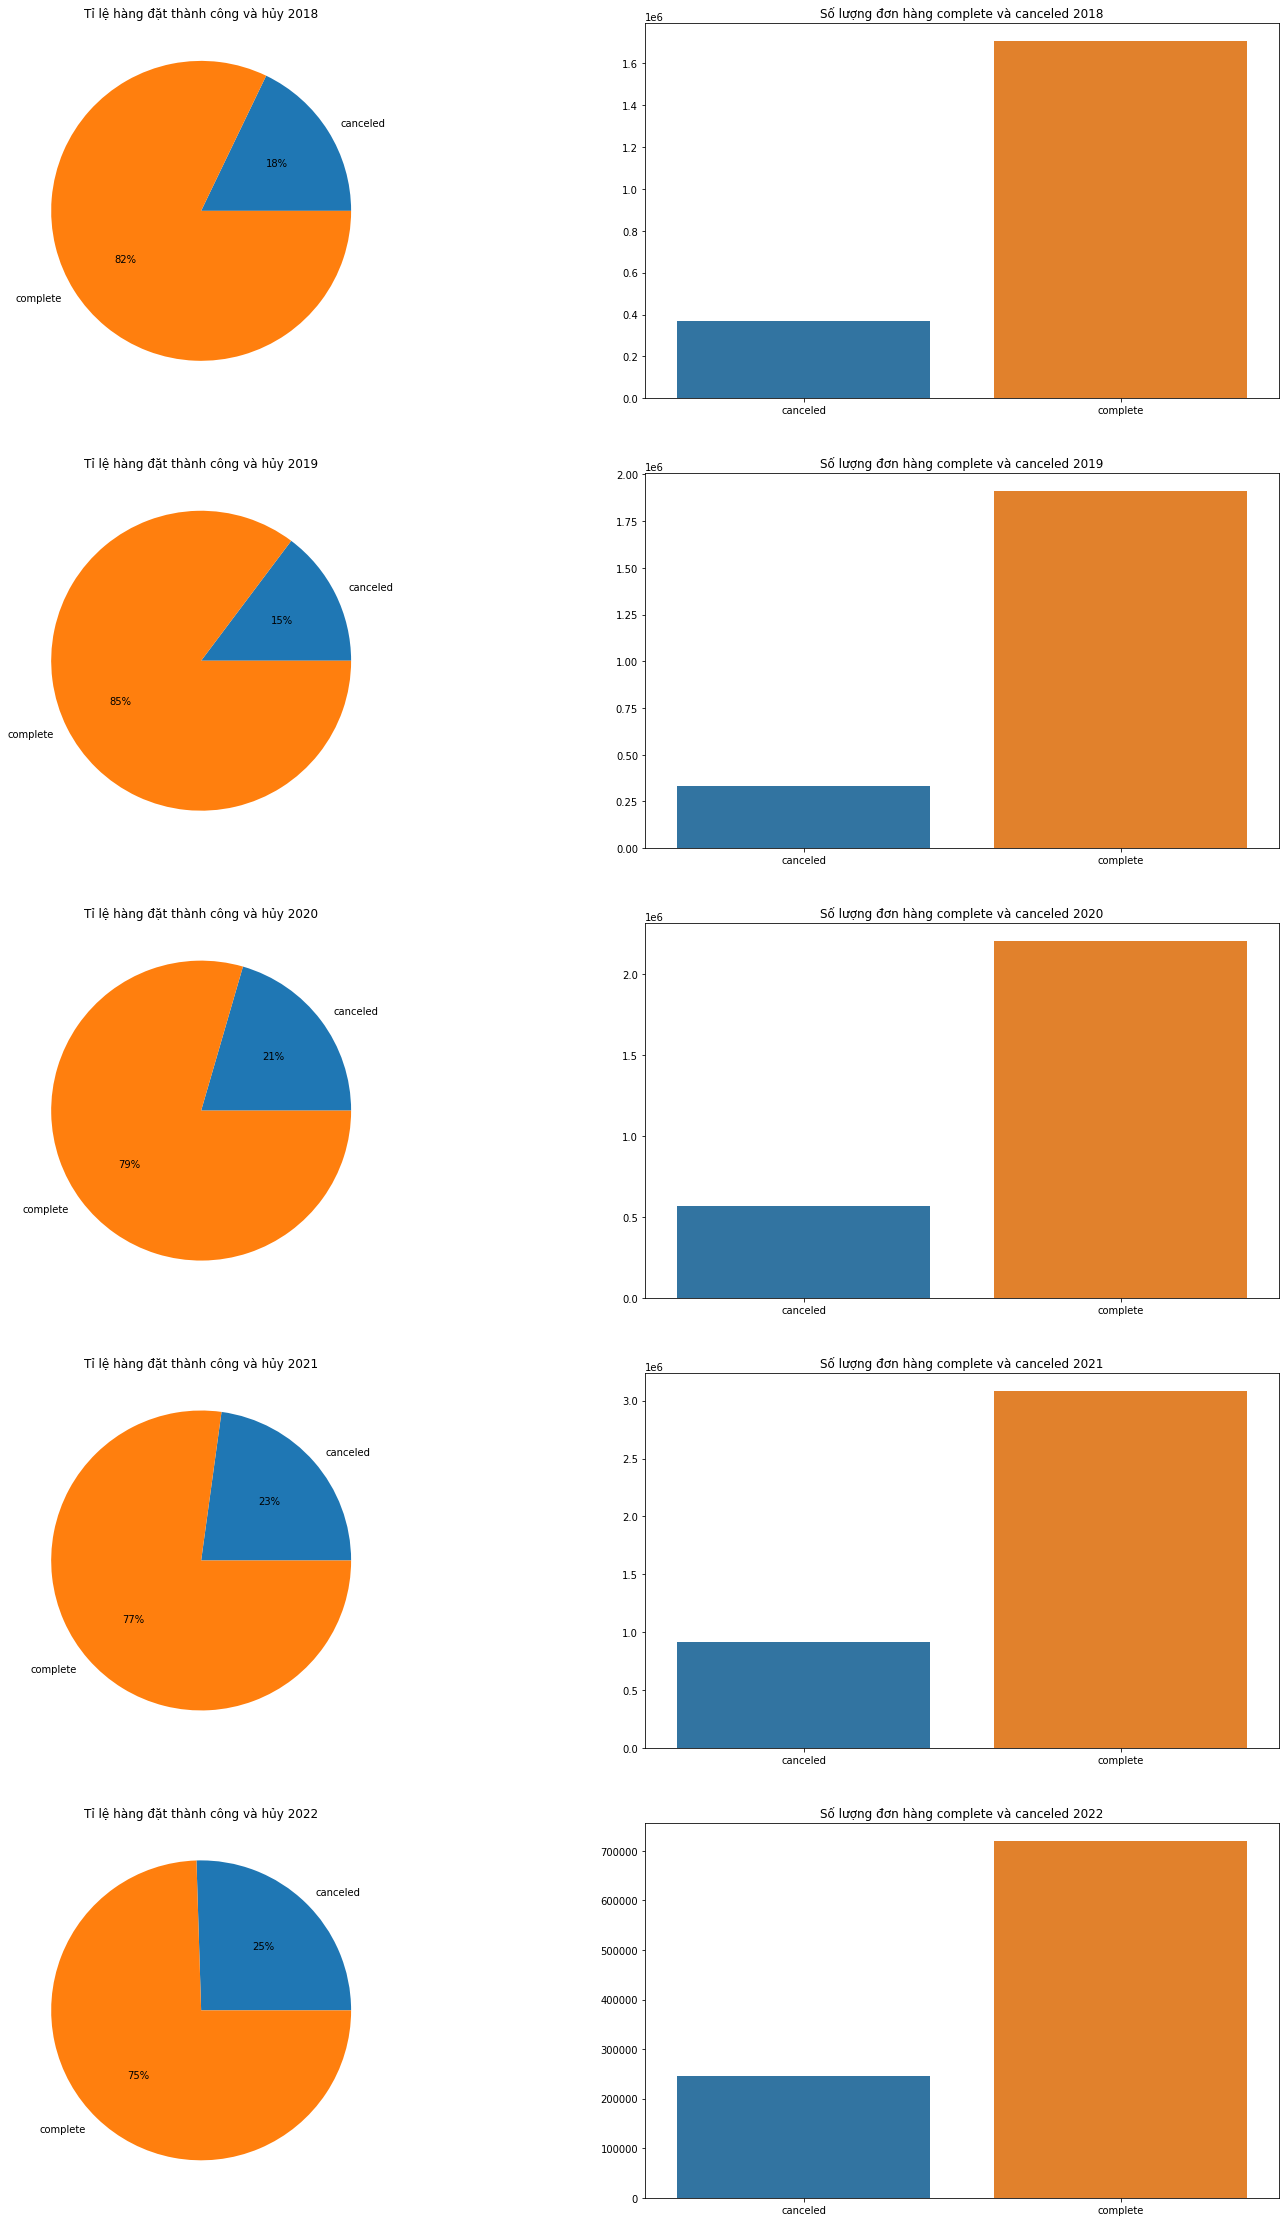

In [126]:
fig, ax = plt.subplots(5, 2, figsize = (25, 40))

for index, df in enumerate(fhs_sales_flat_order_item_state_list):
          df = \
                    df\
                              .loc[(df['fhs_sales_flat_order.state'].isin(['complete', 'canceled']))
                              &    (df['fhs_sales_flat_order.status'].isin(['complete', 'canceled']))]

          df = df  \
                    .groupby(['fhs_sales_flat_order.state'])\
                              ['fhs_sales_flat_order.entity_id'].count()
          df.plot.pie(x = 'fhs_sales_flat_order.state',
                              y = 'fhs_sales_flat_order.entity_id',ax = ax[index, 0], autopct='%1.0f%%')
          ax[index, 0].set_title(f'Tỉ lệ hàng đặt thành công và hủy {2018 + index}')
          ax[index, 0].set_xlabel('')
          ax[index, 0].set_ylabel('')

          df = df.reset_index()
          sns.barplot(data = df, y = 'fhs_sales_flat_order.entity_id',
                    x = 'fhs_sales_flat_order.state', ax = ax[index, 1])
          ax[index, 1].set_title(f'Số lượng đơn hàng complete và canceled {2018 + index}')
          ax[index, 1].set_xlabel('')
          ax[index, 1].set_ylabel('')
          

          


- Lưu lại biến canceled để xí phân tích

- Xử lí với các đơn complete

In [127]:
fhs_sales_flat_order_item_state_2022 = \
          fhs_sales_flat_order_item_state_2022\
                    .loc[(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'].isin(['complete']))]

fhs_sales_flat_order_item_state_2021 = \
          fhs_sales_flat_order_item_state_2021\
                    .loc[(fhs_sales_flat_order_item_state_2021['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2021['fhs_sales_flat_order.status'].isin(['complete']))]

fhs_sales_flat_order_item_state_2020 = \
          fhs_sales_flat_order_item_state_2020\
                    .loc[(fhs_sales_flat_order_item_state_2020['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2020['fhs_sales_flat_order.status'].isin(['complete']))]

fhs_sales_flat_order_item_state_2019 = \
          fhs_sales_flat_order_item_state_2019\
                    .loc[(fhs_sales_flat_order_item_state_2019['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2019['fhs_sales_flat_order.status'].isin(['complete']))]


fhs_sales_flat_order_item_state_2018 = \
          fhs_sales_flat_order_item_state_2018\
                    .loc[(fhs_sales_flat_order_item_state_2018['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2018['fhs_sales_flat_order.status'].isin(['complete']))]

In [133]:
fhs_sales_flat_order_item_state_list = [fhs_sales_flat_order_item_state_2018, fhs_sales_flat_order_item_state_2019, fhs_sales_flat_order_item_state_2020, 
          fhs_sales_flat_order_item_state_2021, fhs_sales_flat_order_item_state_2022]

In [134]:
for i in fhs_sales_flat_order_item_state_list:
          print(len(i))

1704394
1910763
2205181
3084440
720400


- So sánh giữa lượng mua hàng của loại hàng flashsale trong ngày flashsale và trong thời gian flashsale

In [144]:
def show_mean_count_product_month_dayofweek(index, ax):
          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()
          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.boxplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax, palette="tab10")
          ax.set_ylabel('Số lượng')
          ax.set_title(f'Lượng hàng trung bình trong ngày theo tháng năm {2018 + index}')
          ax.set_xlabel('Các tháng trong năm')

def show_mean_count_product_per_sku_month_dayofweek(index, ax):
          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()
          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.boxplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax, palette="tab10")
          ax.set_ylabel('Số lượng')
          ax.set_title(f'Lượng hàng trung bình trong ngày năm {2018 + index}')
          ax.set_xlabel('Các thứ trong tuần')                

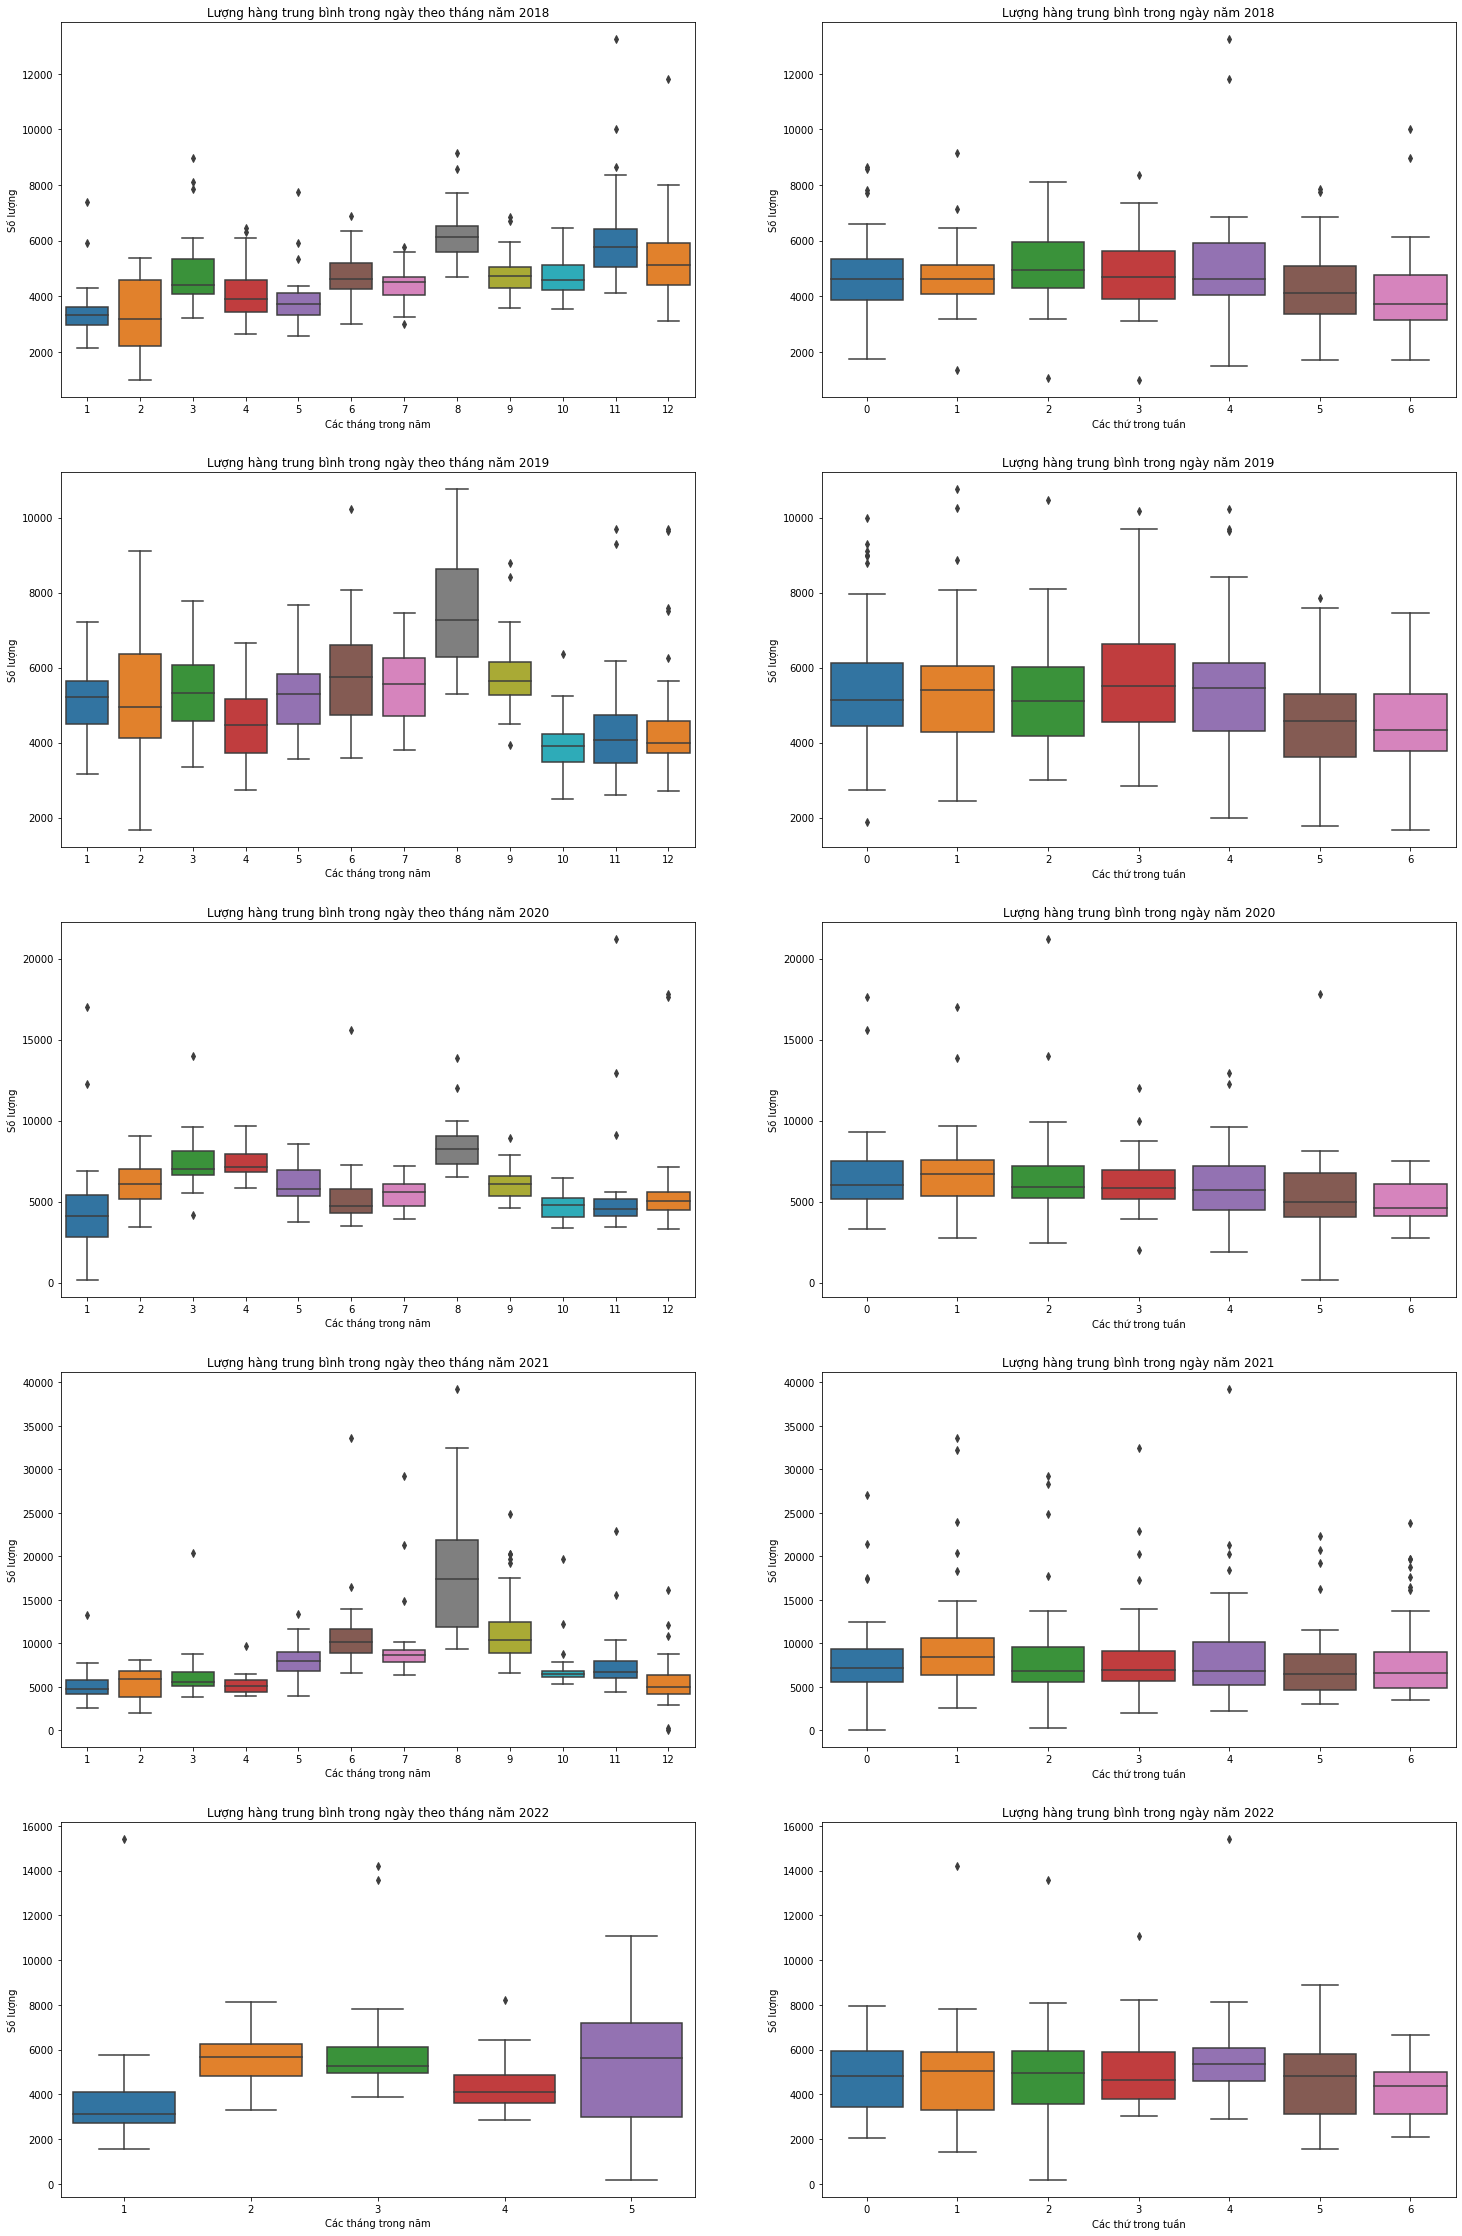

In [149]:
fig, ax = plt.subplots(5, 2, figsize=(25,40))
show_mean_count_product_month_dayofweek(0, ax[0, 0])
show_mean_count_product_month_dayofweek(1, ax[1, 0])
show_mean_count_product_month_dayofweek(2, ax[2, 0])
show_mean_count_product_month_dayofweek(3, ax[3, 0])
show_mean_count_product_month_dayofweek(4, ax[4, 0])

show_mean_count_product_per_sku_month_dayofweek(0, ax[0, 1])
show_mean_count_product_per_sku_month_dayofweek(1, ax[1, 1])
show_mean_count_product_per_sku_month_dayofweek(2, ax[2, 1])
show_mean_count_product_per_sku_month_dayofweek(3, ax[3, 1])
show_mean_count_product_per_sku_month_dayofweek(4, ax[4, 1])

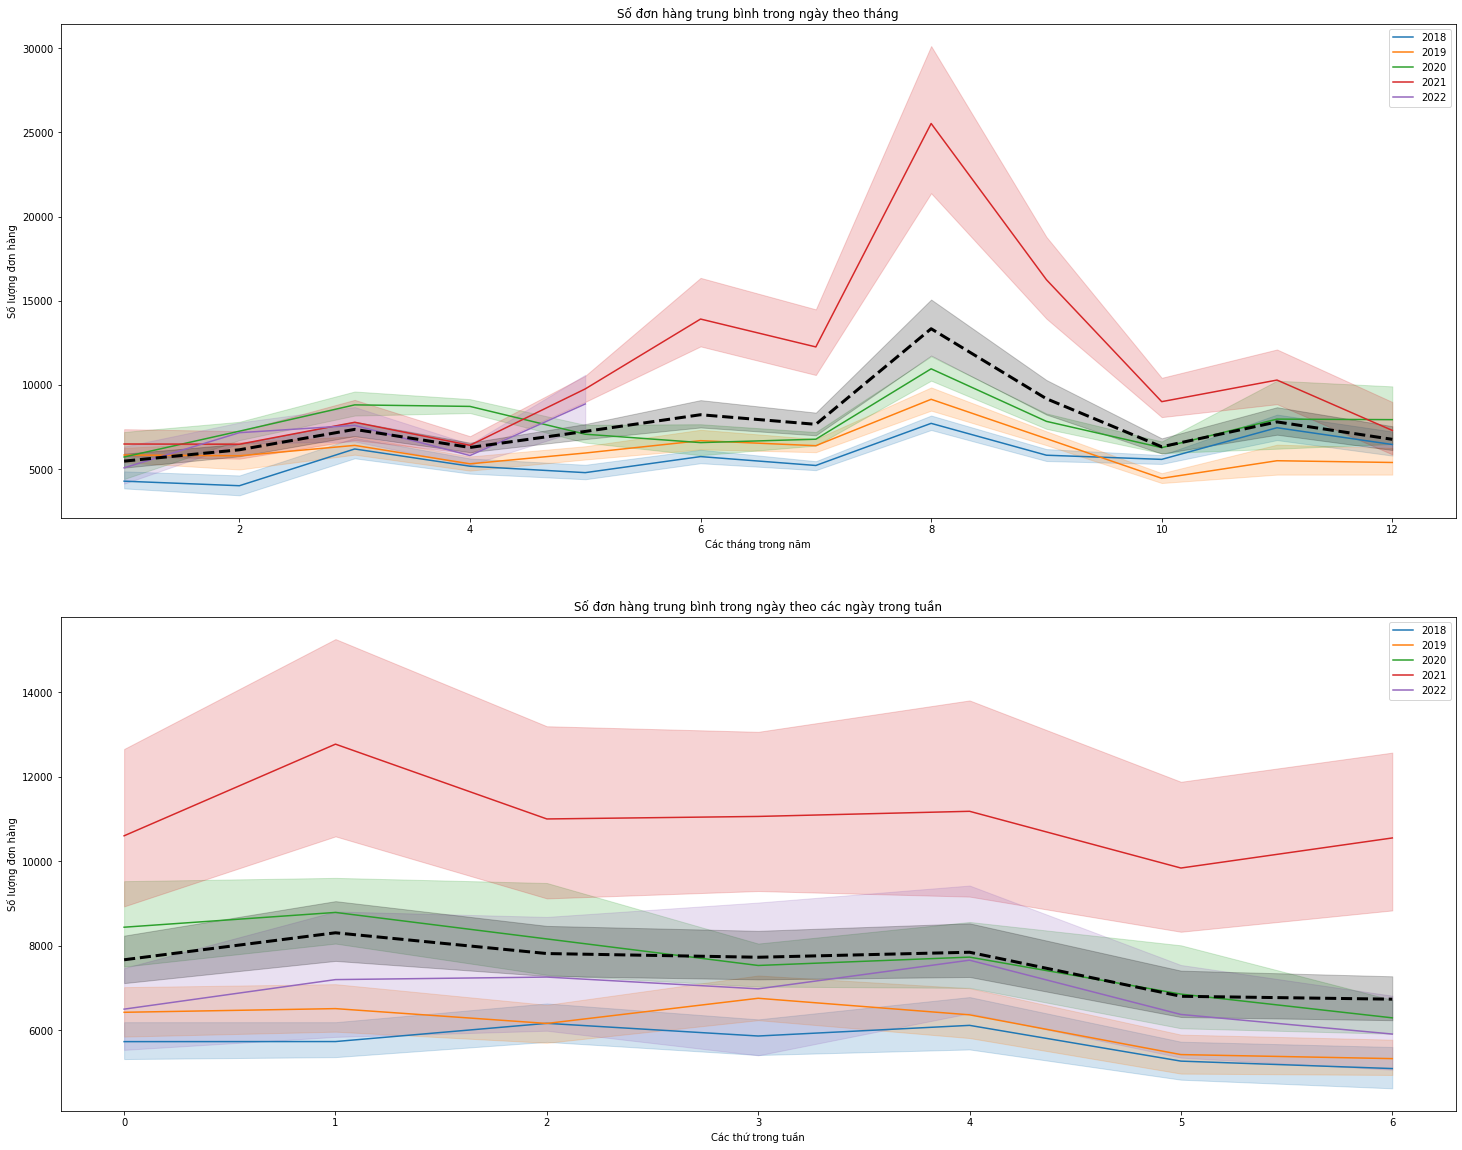

In [209]:
fig, ax = plt.subplots(2,1, figsize = (25, 20))

# vẽ đường trung bình
df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[0],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.month,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[0], palette="tab10", linewidth = 3, color = 'black', linestyle='--')

ax[0].set_title('Số đơn hàng trung bình trong ngày theo tháng')
ax[0].set_xlabel('Các tháng trong năm')
ax[0].set_ylabel('Số lượng đơn hàng')


# vẽ đường trung bình
df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")
sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1], palette="tab10", linewidth = 3, color = 'black', linestyle='--')

ax[1].set_title('Số đơn hàng trung bình trong ngày theo các ngày trong tuần')
ax[1].set_xlabel('Các thứ trong tuần')
ax[1].set_ylabel('Số lượng đơn hàng')

for container in ax[1].containers:
    ax[1].bar_label(container, label_type='edge')

- Show ra các ngày trong tháng

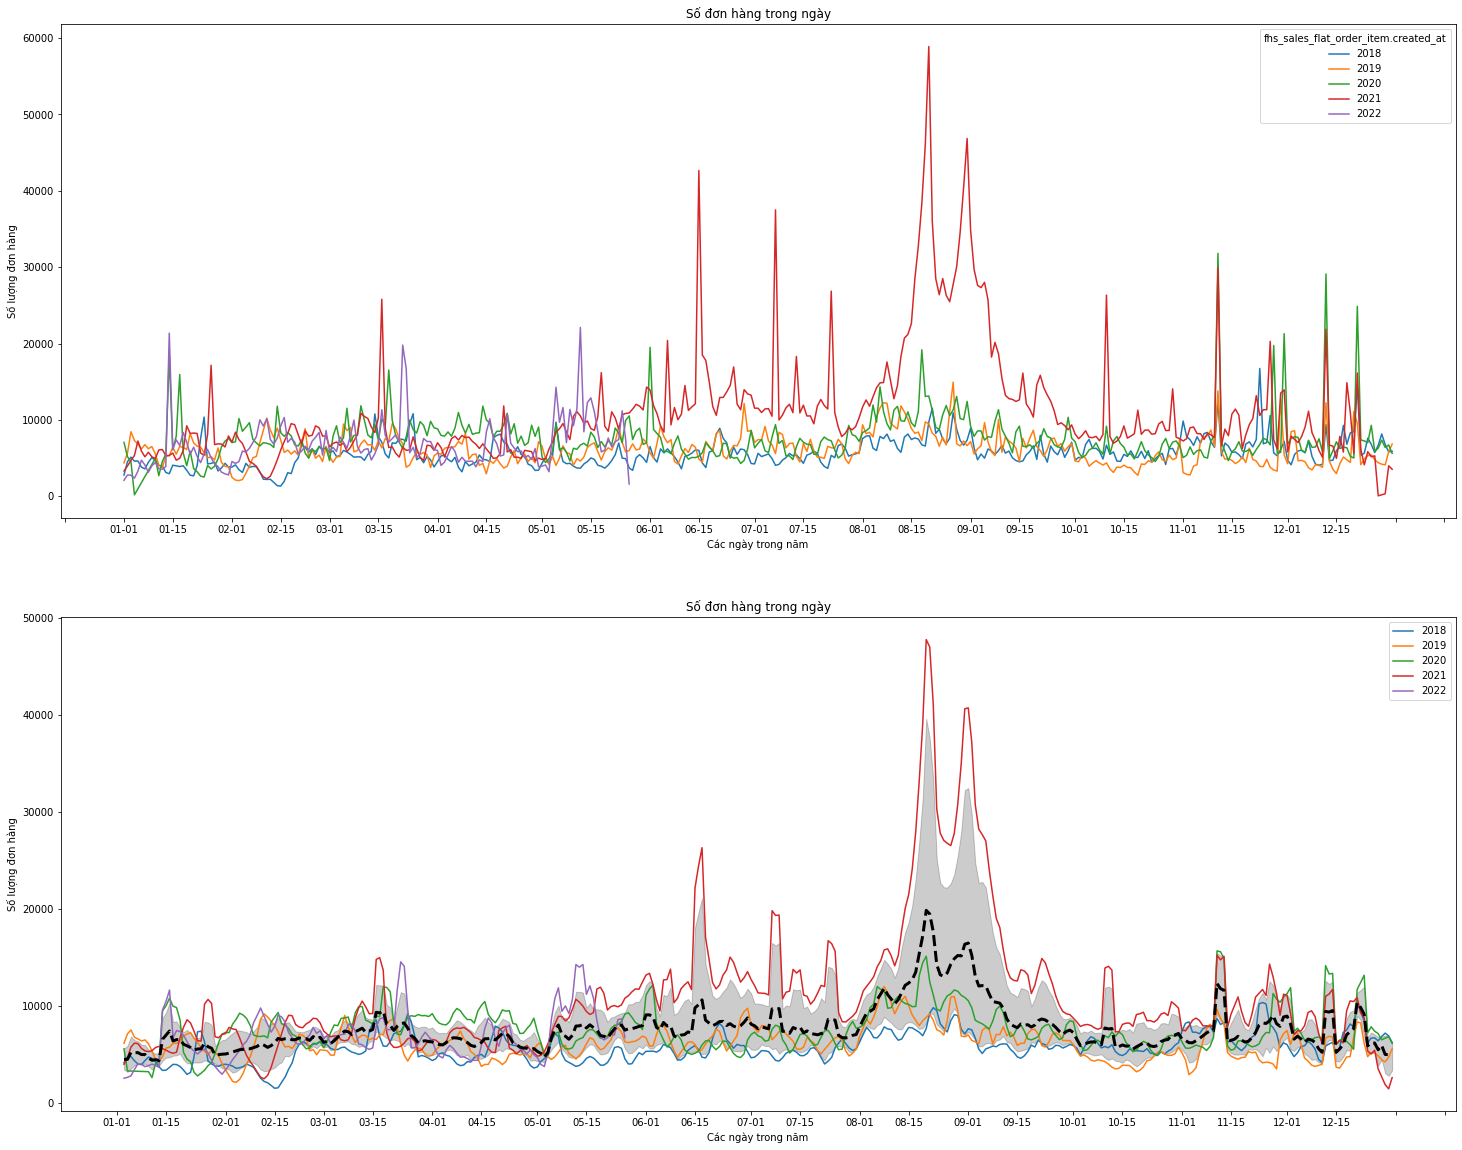

In [192]:


fig, ax = plt.subplots(2,1, figsize = (25, 20))

# vẽ đường trung bình
df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()
df = df.reset_index()
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')
df = df.loc[~(df['fhs_sales_flat_order_item.created_at'].dt.month.eq(2) & df['fhs_sales_flat_order_item.created_at'].dt.day.eq(29))] 

sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.strftime('%m-%d'),
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[0],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")


ax[0].set_title('Số đơn hàng trong ngày')
ax[0].set_xlabel('Các ngày trong năm')
ax[0].set_ylabel('Số lượng đơn hàng')
ax[0].xaxis.set_major_locator(mdates.DayLocator((1,15)))

df = df.sort_values('fhs_sales_flat_order_item.created_at')

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2018, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2018]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2019, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2019]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2020, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2020]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2021, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2021]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2022, 'fhs_sales_flat_order.entity_id'] \
          = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.year == 2022]['fhs_sales_flat_order.entity_id'].rolling(3).mean()

sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.strftime('%m-%d'),
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1],
                    hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10", alpha  =1)

sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.strftime('%m-%d'),
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax[1], palette="tab10", linewidth = 3, color = 'black', linestyle='--')

ax[1].set_title('Số đơn hàng trong ngày')
ax[1].set_xlabel('Các ngày trong năm')
ax[1].set_ylabel('Số lượng đơn hàng')
ax[1].xaxis.set_major_locator(mdates.DayLocator((1,15)))


In [206]:
def show_line_count_product_dayinmonth(index, ax1, ax2):

          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
          .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                    ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()

          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.month, palette="tab10")

          ax1.set_title(f'Đơn hàng theo ngày vào các tháng năm {2018 + index}')
          ax1.legend(title = 'Tháng')
          ax1.set_xlabel('Ngày trong tháng')
          ax1.set_ylabel('Số đơn hàng')
          

          df = df.sort_values('fhs_sales_flat_order_item.created_at')
          df['fhs_sales_flat_order.entity_id'] \
                    = df['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.month, palette="tab10")
                    
          sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax2, linewidth = 3, color = 'black', linestyle='--')

          ax2.set_title(f'Moving Average lượng hàng hóa năm {2018 + index}')
          ax2.legend(title = 'Tháng')
          ax2.set_xlabel('Ngày trong tháng')
          ax2.set_ylabel('Số đơn hàng')


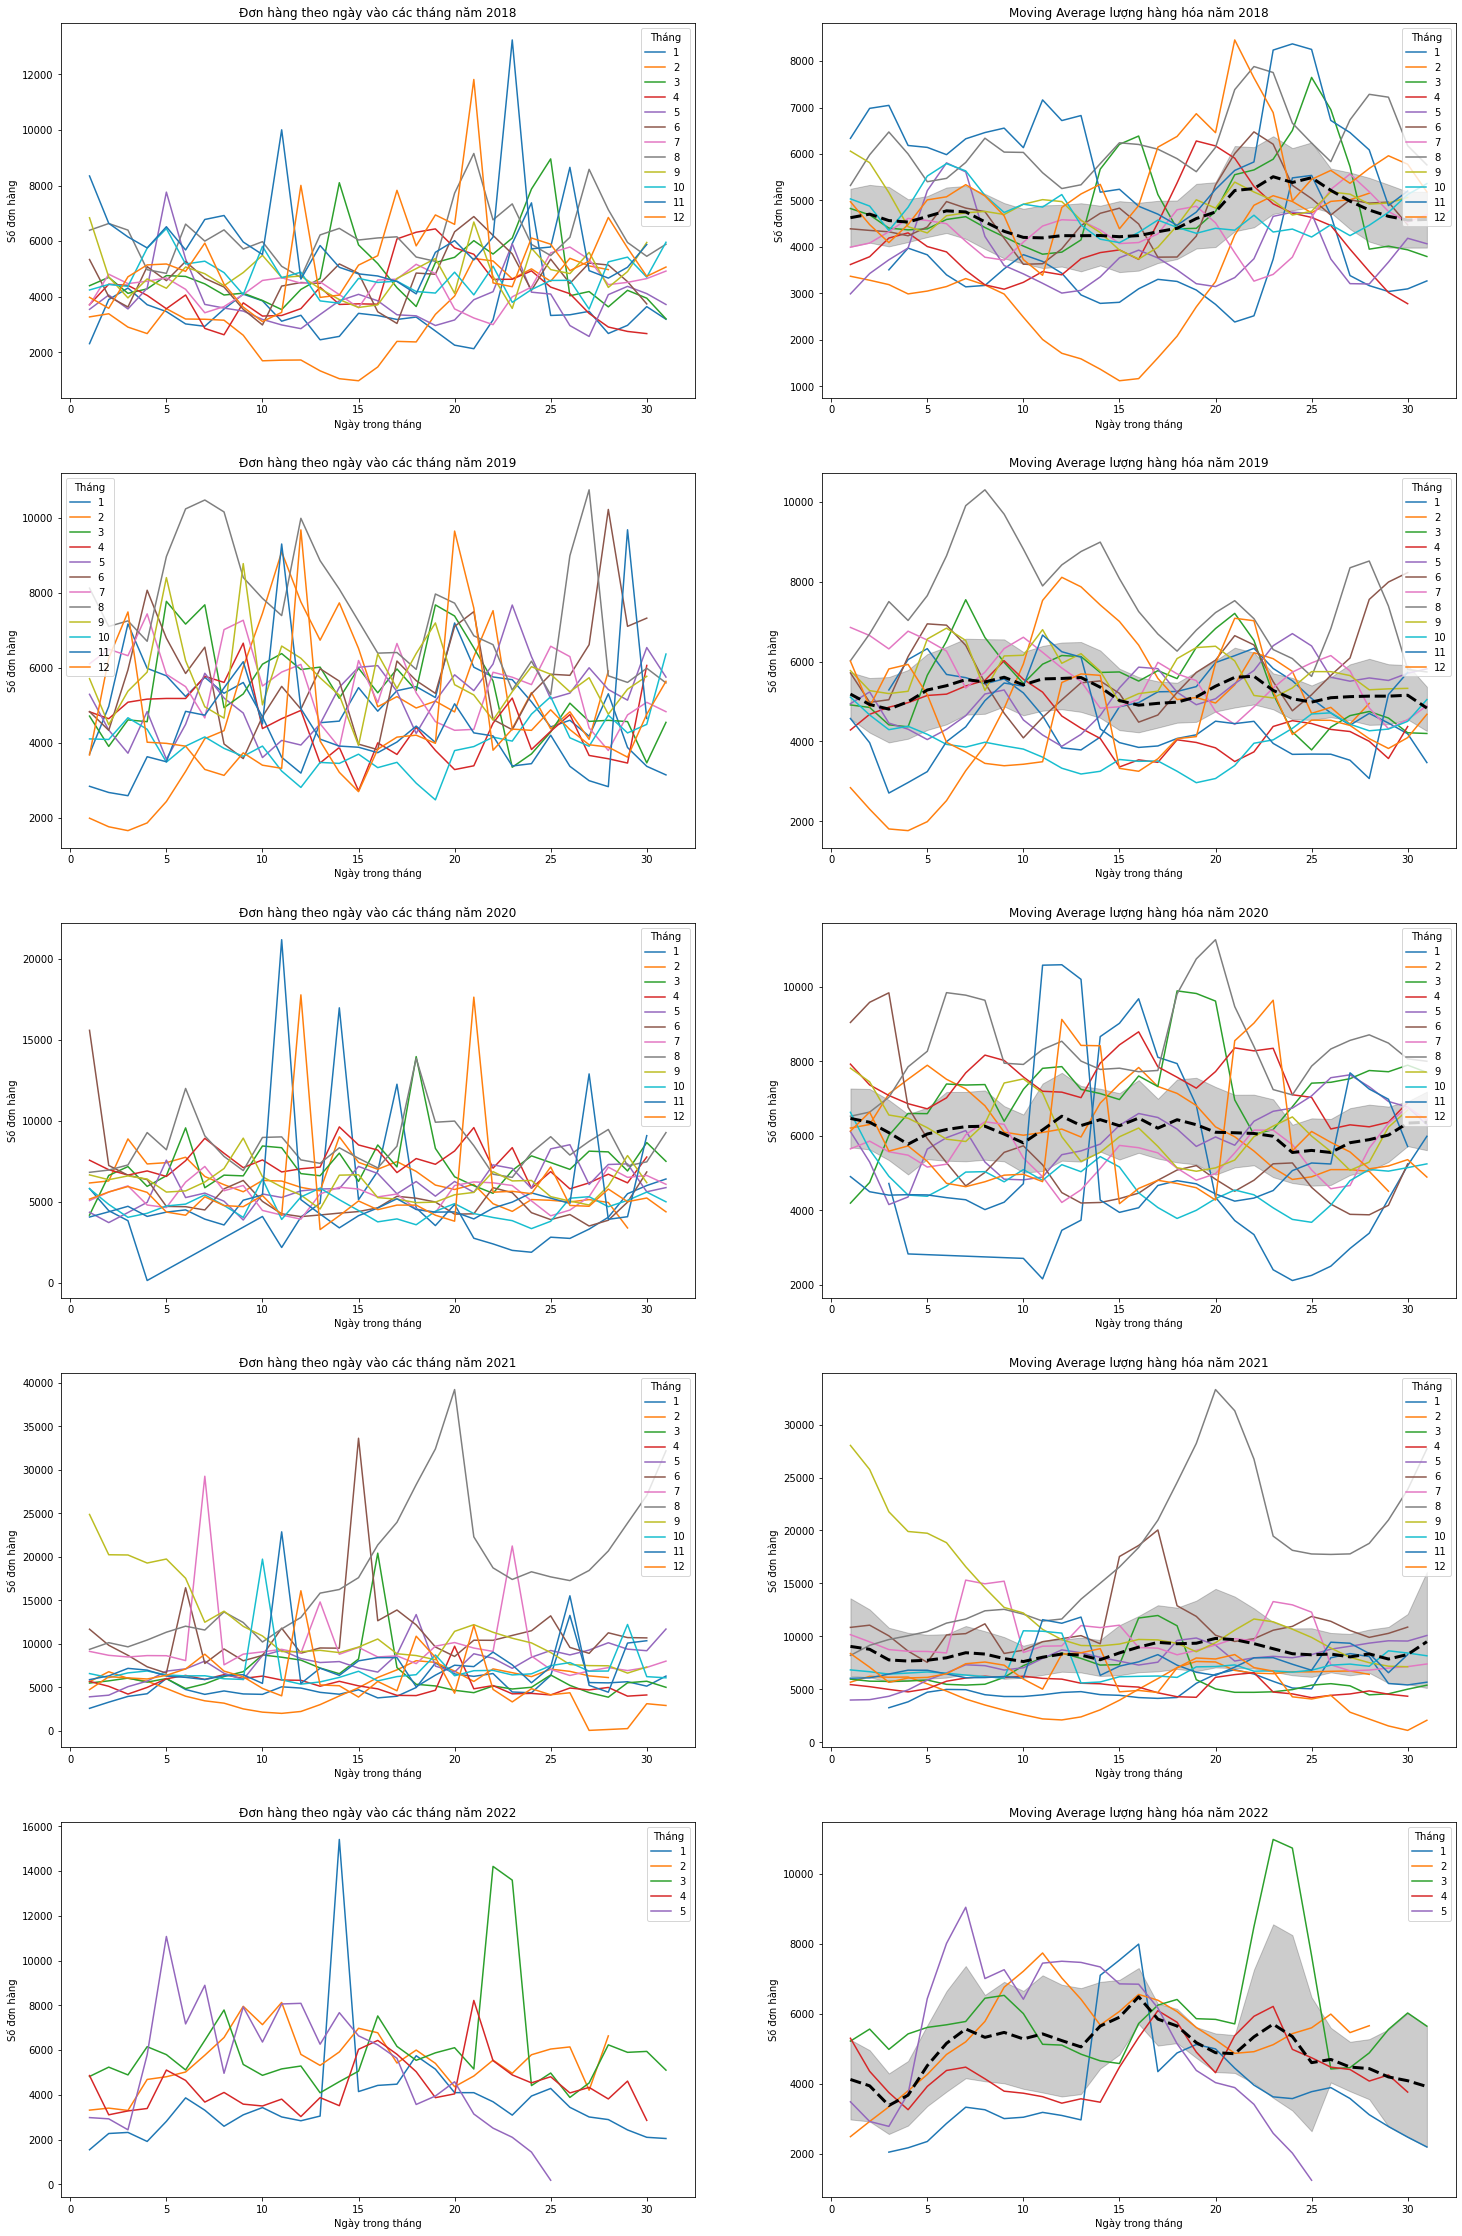

In [210]:
fig, ax = plt.subplots(5,2, figsize = (25, 40))
show_line_count_product_dayinmonth(0, ax[0, 0], ax[0, 1])
show_line_count_product_dayinmonth(1, ax[1, 0], ax[1, 1])
show_line_count_product_dayinmonth(2, ax[2, 0], ax[2, 1])
show_line_count_product_dayinmonth(3, ax[3, 0], ax[3, 1])
show_line_count_product_dayinmonth(4, ax[4, 0], ax[4, 1])

In [219]:
def show_line_count_product_month_every_year(month, ax1, ax2):
          df = fhs_sales_flat_order_item_state_2018_2022         \
                    .groupby([fhs_sales_flat_order_item_state_2018_2022['fhs_sales_flat_order_item.created_at'].dt.date])\
                              ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()

          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          df = df.loc[df['fhs_sales_flat_order_item.created_at'].dt.month == month]
          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")

          ax1.set_title(f'Đơn hàng tháng {month} vào các năm')
          ax1.legend(title = 'Năm')
          ax1.set_xlabel('Ngày trong tháng')
          ax1.set_ylabel('Số đơn hàng')


          df = df.sort_values('fhs_sales_flat_order_item.created_at')
          df['fhs_sales_flat_order.entity_id'] \
                    = df['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.year, palette="tab10")
          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.day,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2, linewidth = 3, color = 'black', linestyle='--')

          ax2.set_title(f'Moving Average Đơn hàng tháng {month} vào các năm')
          ax2.legend(title = 'Năm')
          ax2.set_xlabel('Ngày trong tháng')
          ax2.set_ylabel('Số đơn hàng')

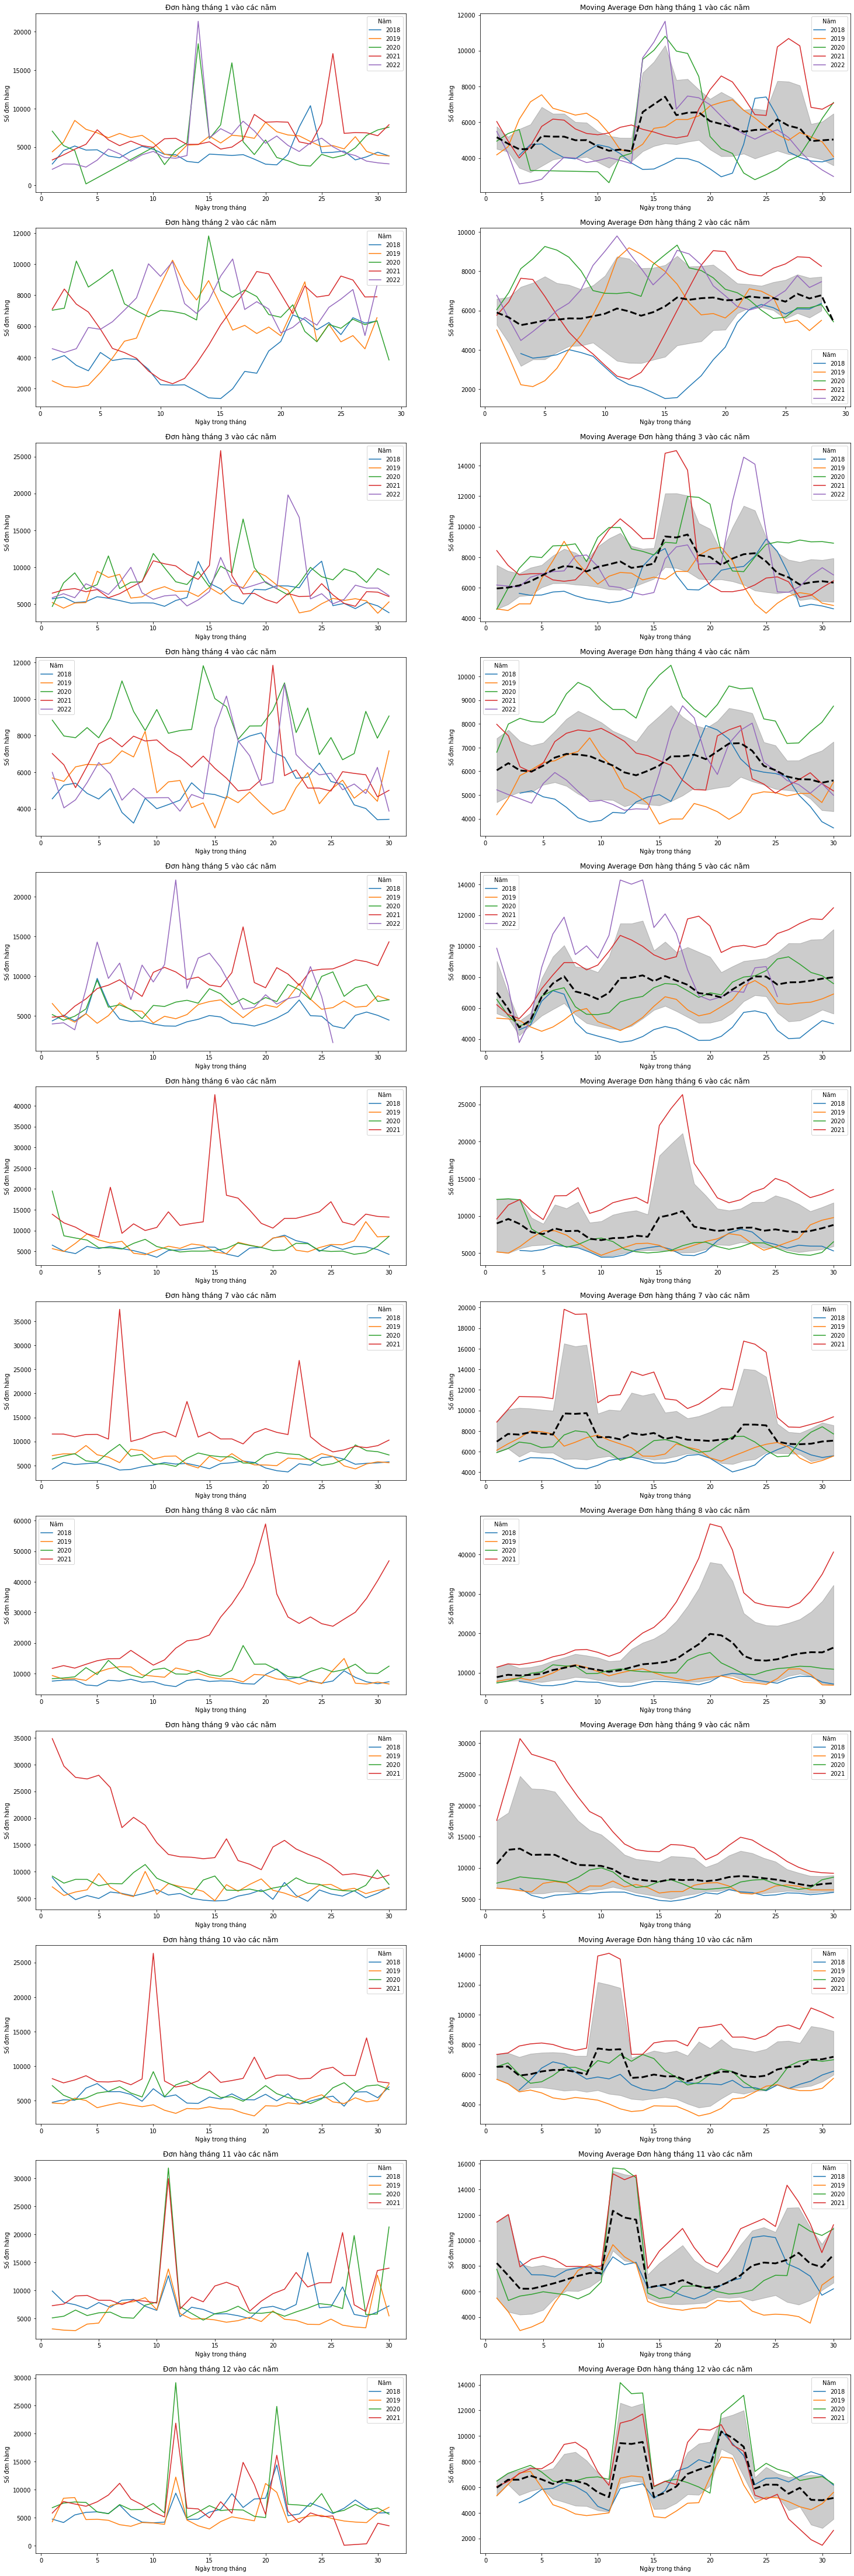

In [220]:
fig, ax = plt.subplots(12,2, figsize = (25, 80))

for i in range(1, 13):
          show_line_count_product_month_every_year(i, ax[i - 1, 0], ax[i - 1, 1])


In [234]:
def show_line_count_product_dayinweek(index, ax1, ax2):

          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
          .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date])\
                    ['fhs_sales_flat_order.entity_id'].count()

          # reset index đưa về dataframe
          df = df.reset_index()

          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")

          ax1.set_title(f'Đơn hàng theo thứ trong tuần năm {2018 + index}')
          ax1.set_xlabel('Thứ trong tuần')
          ax1.set_ylabel('Số đơn hàng')
          ax1.get_legend().remove()
          

          # df = df.sort_values('fhs_sales_flat_order_item.created_at')
          # df['fhs_sales_flat_order.entity_id'] \
          #           = df['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
                              hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")
                    
          sns.lineplot(data = df, 
                    x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
                    y = df['fhs_sales_flat_order.entity_id'], ax = ax2, linewidth = 3, color = 'black', linestyle='--')

          ax2.set_title(f'Lượng hàng hóa năm {2018 + index}')
          ax2.set_xlabel('Thứ trong tuần')
          ax2.set_ylabel('Số đơn hàng')
          ax2.get_legend().remove()


/tmp/ipykernel_90311/214290428.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")
/tmp/ipykernel_90311/214290428.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")
/tmp/ipykernel_90311/214290428.py:18: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")
/tmp/ipykernel_90311/214290428.py:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  hue = df['fhs_sales_flat_order_item.created_at'].dt.week, palette="tab10")
/tmp/ipykernel_90311/214290428.py:18

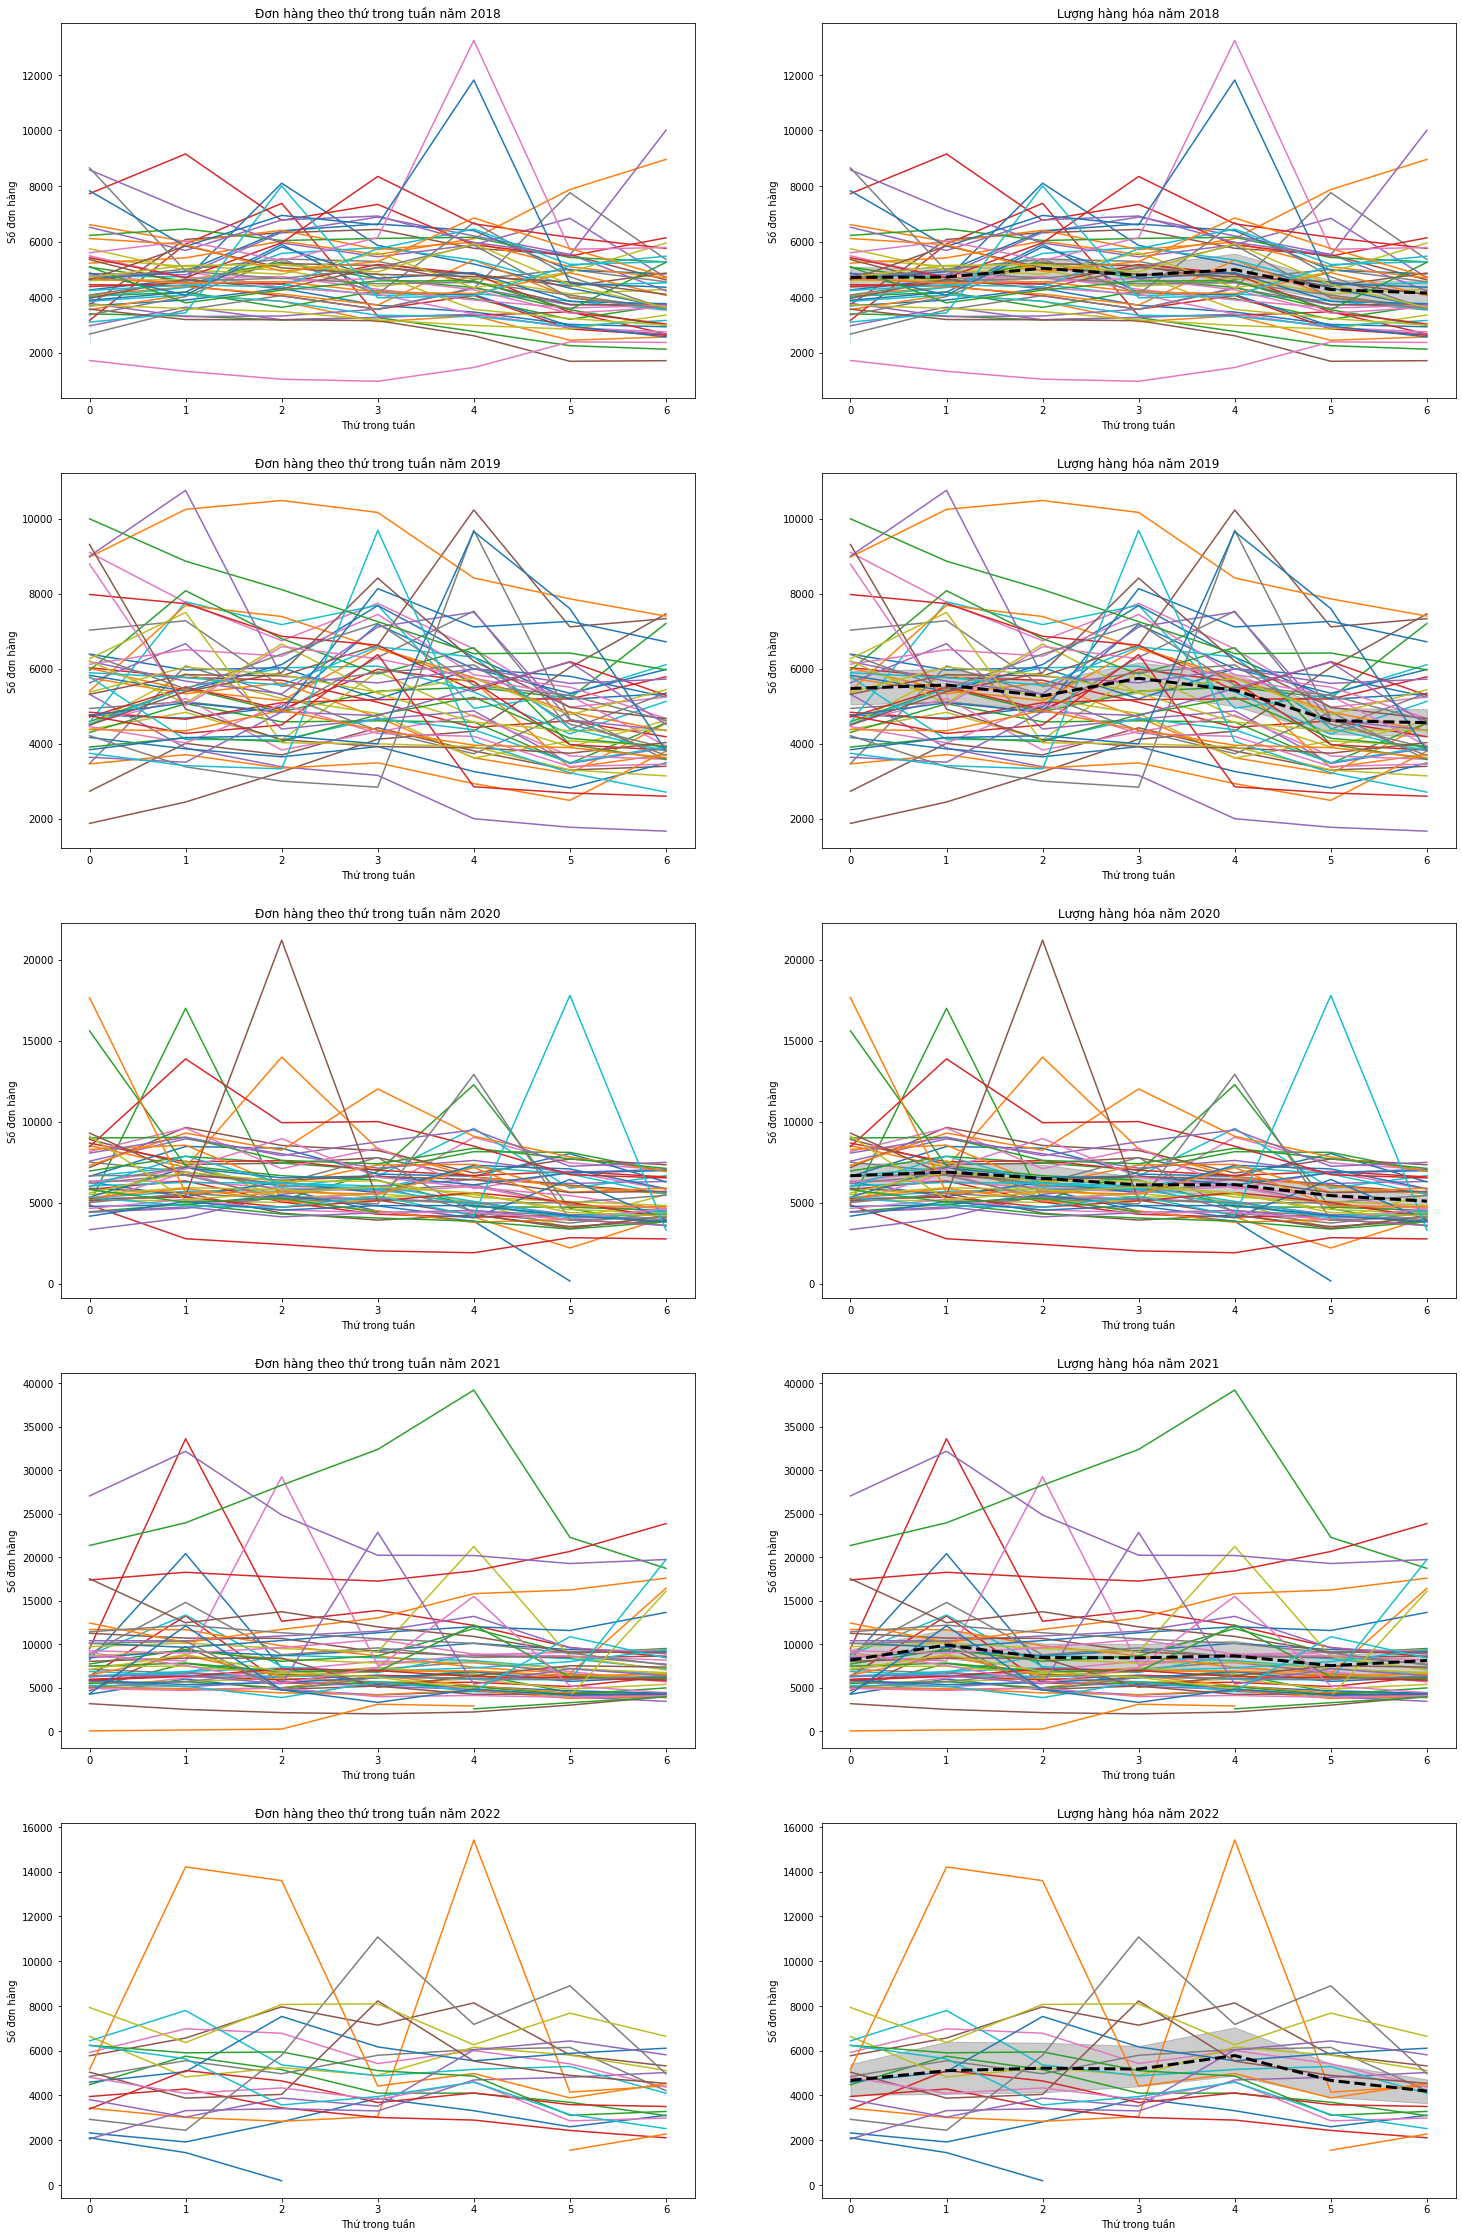

In [235]:
fig, ax = plt.subplots(5,2, figsize = (25, 40))
show_line_count_product_dayinweek(0, ax[0,0], ax[0,1])
show_line_count_product_dayinweek(1, ax[1,0], ax[1,1])
show_line_count_product_dayinweek(2, ax[2,0], ax[2,1])
show_line_count_product_dayinweek(3, ax[3,0], ax[3,1])
show_line_count_product_dayinweek(4, ax[4,0], ax[4,1])

In [262]:
df = fhs_sales_flat_order_item_state_list[index]

df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.hour])\
                    ['fhs_sales_flat_order.entity_id'].count()
df.index.names = ['fhs_sales_flat_order_item.created_at_date', 
                    'fhs_sales_flat_order_item.created_at_hour']
# reset index đưa về dataframe
df = df.reset_index()
# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')

df = df.groupby([df['fhs_sales_flat_order_item.created_at_date'], df['fhs_sales_flat_order_item.created_at_hour']])\
          ['fhs_sales_flat_order.entity_id'].aggregate('first').unstack()
# df = df.reset_index()
df

fhs_sales_flat_order_item.created_at_hour     0     1     2     3    4     5   \
fhs_sales_flat_order_item.created_at_date                                       
2022-01-01                                 186.0  29.0  21.0   NaN  NaN   5.0   
2022-01-02                                  33.0  48.0  19.0   8.0  3.0   3.0   
2022-01-03                                 121.0  15.0   NaN  11.0  7.0  15.0   
2022-01-04                                  71.0  36.0  29.0   3.0  NaN   1.0   
2022-01-05                                  20.0  20.0   NaN   7.0  5.0   NaN   
...                                          ...   ...   ...   ...  ...   ...   
2022-05-21                                 174.0  42.0  12.0   7.0  NaN   9.0   
2022-05-22                                 149.0  30.0  18.0   2.0  NaN  11.0   
2022-05-23                                  73.0  15.0  18.0   NaN  1.0   6.0   
2022-05-24                                  46.0  26.0   NaN   3.0  NaN  24.0   
2022-05-25                                  13.0   7.0   1.0   NaN  NaN   NaN   

fhs_sales_flat_order_item.created_at_hour    6     7      8      9   ...  \
fhs_sales_flat_order_item.created_at_date                            ...   
2022-01-01                                  7.0  49.0   84.0  187.0  ...   
2022-01-02                                  4.0  61.0   33.0  117.0  ...   
2022-01-03                                 29.0  49.0   36.0  163.0  ...   
2022-01-04                                 12.0  11.0   13.0   51.0  ...   
2022-01-05                                 48.0  29.0  109.0  155.0  ...   
...                                         ...   ...    ...    ...  ...   
2022-05-21                                 30.0  44.0  130.0  218.0  ...   
2022-05-22                                 26.0  47.0   68.0  183.0  ...   
2022-05-23                                 28.0  15.0   84.0  150.0  ...   
2022-05-24                                 38.0  54.0   73.0  217.0  ...   
2022-05-25                                  1.0   3.0   25.0   19.0  ...   

fhs_sales_flat_order_item.created_at_hour     14     15     16     17     18  \
fhs_sales_flat_order_item.created_at_date                                      
2022-01-01                                   NaN    NaN    NaN    NaN   44.0   
2022-01-02                                 129.0  110.0  103.0  140.0  177.0   
2022-01-03                                 113.0  140.0  171.0   93.0  132.0   
2022-01-04                                 155.0  121.0  113.0  127.0   54.0   
2022-01-05                                 175.0  110.0  134.0  129.0  186.0   
...                                          ...    ...    ...    ...    ...   
2022-05-21                                 129.0  195.0  186.0  151.0  166.0   
2022-05-22                                 142.0  123.0  143.0  151.0  117.0   
2022-05-23                                 120.0  110.0   97.0   94.0   65.0   
2022-05-24                                  86.0   43.0   43.0   52.0   15.0   
2022-05-25                                   NaN    NaN    NaN    NaN    NaN   

fhs_sales_flat_order_item.created_at_hour     19     20     21     22     23  
fhs_sales_flat_order_item.created_at_date                                     
2022-01-01                                 156.0  162.0  185.0  125.0   88.0  
2022-01-02                                 104.0  270.0  149.0  167.0  101.0  
2022-01-03                                 106.0  196.0  189.0   89.0   65.0  
2022-01-04                                 113.0  214.0  158.0   97.0   40.0  
2022-01-05                                 212.0  300.0  188.0  195.0  152.0  
...                                          ...    ...    ...    ...    ...  
2022-05-21                                 240.0  144.0  233.0  146.0   97.0  
2022-05-22                                 129.0  120.0  195.0  125.0   55.0  
2022-05-23                                  97.0  155.0  170.0  118.0   81.0  
2022-05-24                                  21.

In [248]:
def show_line_count_product_hour(index, ax1, ax2):

          df = fhs_sales_flat_order_item_state_list[index]

          df = df         \
                    .groupby([df['fhs_sales_flat_order_item.created_at'].dt.date,
                              df['fhs_sales_flat_order_item.created_at'].dt.hour])\
                              ['fhs_sales_flat_order.entity_id'].count()
          df.index.names = ['fhs_sales_flat_order_item.created_at_date', 
                              'fhs_sales_flat_order_item.created_at_hour']
          # reset index đưa về dataframe
          df = df.reset_index()
          # khi reset_index inedx đã đưa về sting nên ta cast về datetime
          string_to_datetime(df, 'fhs_sales_flat_order_item.created_at_date')

          sns.lineplot(data = df, 
                              x = df['fhs_sales_flat_order_item.created_at_hour'],
                              y = df['fhs_sales_flat_order.entity_id'], ax = ax1,
                              hue = df['fhs_sales_flat_order_item.created_at_date'].dt.date, palette="tab10")

          ax1.set_title(f'Đơn hàng theo thứ trong tuần năm {2018 + index}')
          ax1.set_xlabel('Thứ trong tuần')
          ax1.set_ylabel('Số đơn hàng')
          ax1.get_legend().remove()
          

          # df = df.sort_values('fhs_sales_flat_order_item.created_at')
          # df['fhs_sales_flat_order.entity_id'] \
          #           = df['fhs_sales_flat_order.entity_id'].rolling(3).mean()

          # sns.lineplot(data = df, 
          #                     x = df['fhs_sales_flat_order_item.created_at_hour'],
          #                     y = df['fhs_sales_flat_order.entity_id'], ax = ax2,
          #                     hue = df['fhs_sales_flat_order_item.created_at_date'].dt.date, palette="tab10")
                    
          # sns.lineplot(data = df, 
          #           x = df['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          #           y = df['fhs_sales_flat_order.entity_id'], ax = ax2, linewidth = 3, color = 'black', linestyle='--')

          # ax2.set_title(f'Moving Average lượng hàng hóa năm {2018 + index}')
          # ax2.set_xlabel('Thứ trong tuần')
          # ax2.set_ylabel('Số đơn hàng')
          # ax2.get_legend().remove()

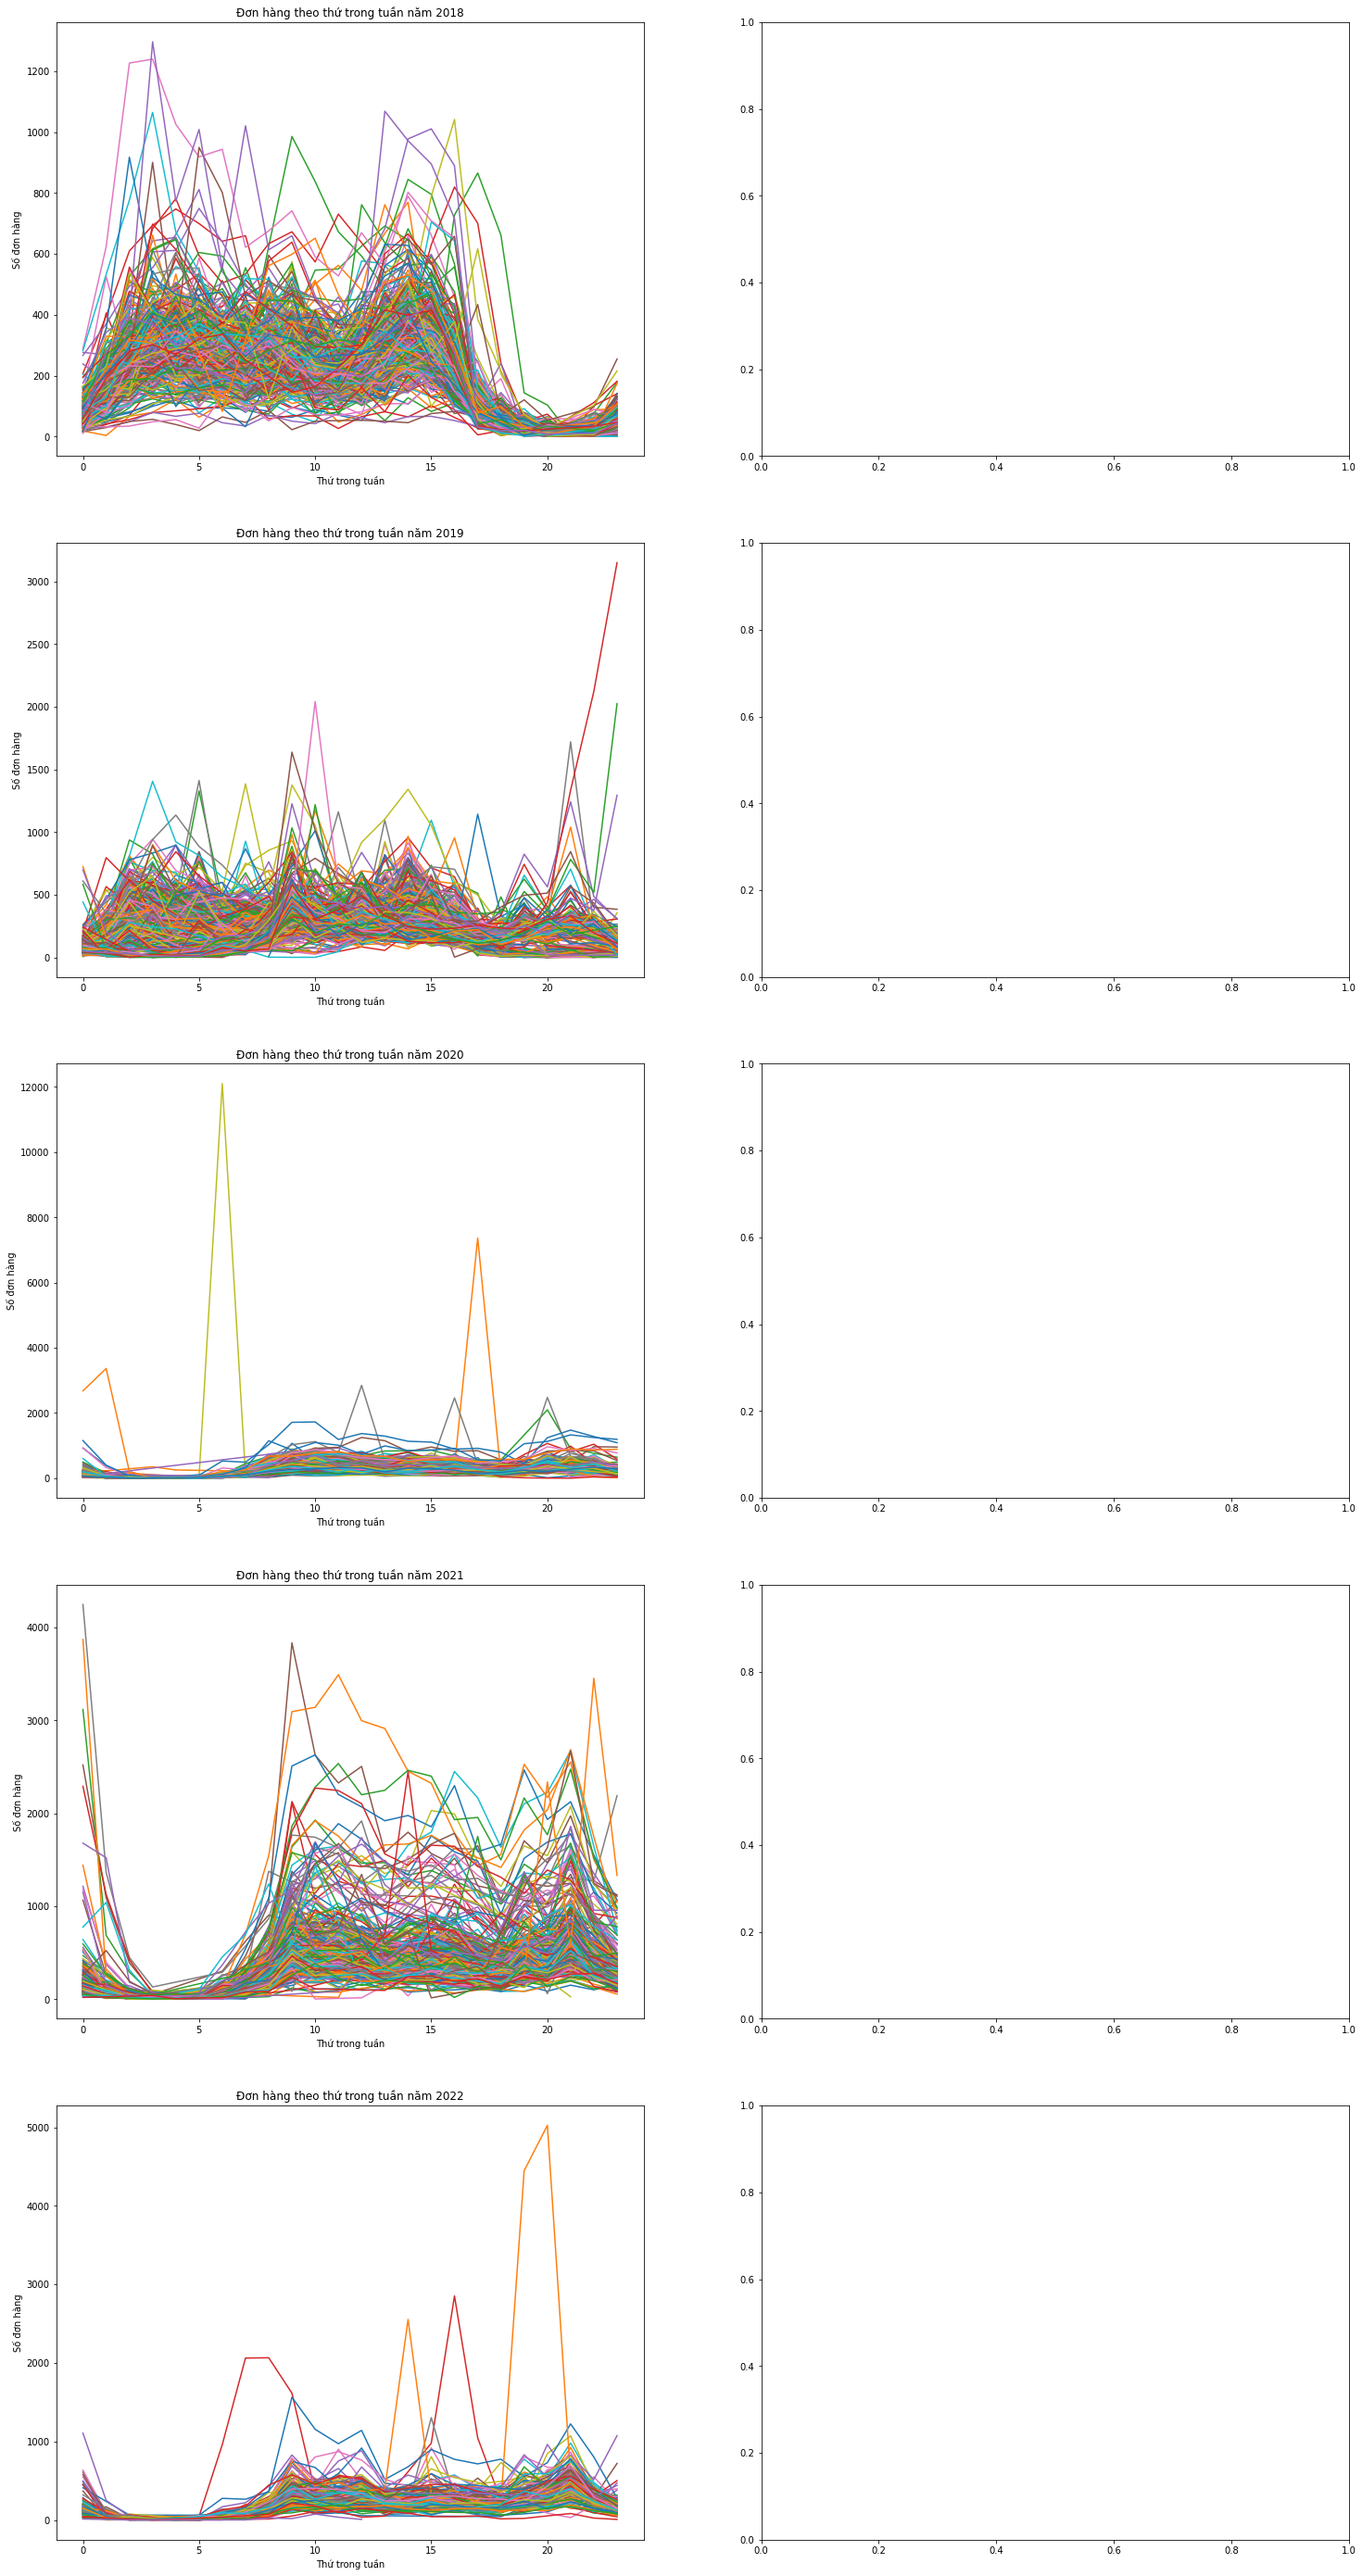

In [251]:
fig, ax = plt.subplots(5,2, figsize = (25, 50))
show_line_count_product_hour(0, ax[0, 0], ax[0, 1])
show_line_count_product_hour(1, ax[1, 0], ax[1, 1])
show_line_count_product_hour(2, ax[2, 0], ax[2, 1])
show_line_count_product_hour(3, ax[3, 0], ax[3, 1])
show_line_count_product_hour(4, ax[4, 0], ax[4, 1])

- Check cực đại có phải ngày flashsale hay không, số lượng bán của hàng flashsale.
- Kiếm tra chính xác ngày trùng thnag1 7/7 8/8 9/9